In [35]:
import argparse
import os
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.modeling.backbone import build_backbone
from maskrcnn_benchmark.modeling.ld_head import build_gfn, build_heads
from maskrcnn_benchmark.modeling.hourglass import build_hourglass
from maskrcnn_benchmark.modeling.detector import build_lane_detection_model

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i%m]

cfg.merge_from_file('e2e_mask_rcnn_R_50_FPN_1x.yaml')

In [ ]:
'''
checkpoint = torch.load('e2e_mask_rcnn_R_50_FPN_1x.pth', map_location=torch.device("cpu"))
ks = []
for k, _ in checkpoint['model'].items():
    if 'module.rpn' in k or 'module.roi_heads' in k:
        ks.append(k)
print(ks)
model_param = checkpoint['model']
for k in ks:
    model_param.pop(k)
new_cp = {}
new_cp['model'] = model_param
# optimizer, scheduler, iteration
torch.save(new_cp, 'e2e_mask_rcnn_R_50_FPN_BB.pth')
'''

In [249]:
cp = torch.load("exp/oct28/model_0028000.pth", map_location=torch.device("cpu"))
ncp = {"model": cp["model"]}
torch.save(ncp, "exp/oct29/init.pth")

In [2]:
from maskrcnn_benchmark.data import make_data_loader
data_loader = make_data_loader(
    cfg,
    is_train=True,
    is_distributed=False,
    start_iter=0,
)
dataset = data_loader.dataset

In [3]:
img_orig, target, idx = dataset.__getitem__(102)
gt_loc = target['gt_loc']
gt_cls = target['gt_cls']
gt_ins = target['gt_ins']
encode_ins = target['encode_ins']

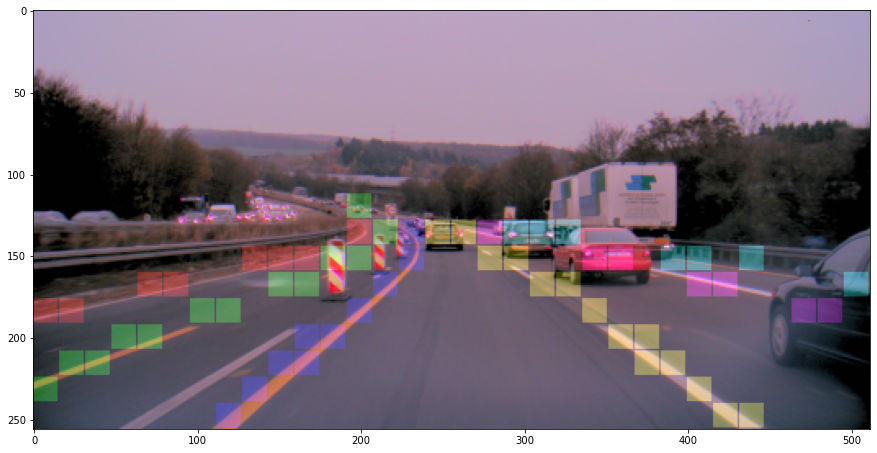

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = img_orig.permute(1, 2, 0).contiguous()
img = img.numpy()
# img = np.transpose(img_orig, (1, 2, 0)).astype('float32')
img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
img = (img * 255).astype(np.uint8)
blk = np.zeros(img.shape, np.uint8)

for h in range(16):
    for w in range(32):
        k = int(encode_ins[0,h,w])
        if k > 0:
            pt1 = ( w*16, h*16  )
            pt2 = ( w*16+14, h*16+14 )
            # cv2.circle(img, (x,y), 1, get_color(k-1), -1)
            cv2.rectangle(blk, pt1, pt2, get_color(k-1), cv2.FILLED)

out = cv2.addWeighted(img, 1.0, blk, 0.25, 1)
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.imshow(blk)
plt.imshow(out)
plt.show() 

In [22]:
from maskrcnn_benchmark.data.utils.auto_lane_pointlane_codec  import PointLaneCodec
from maskrcnn_benchmark.data.utils.auto_lane_codec_utils import nms_with_pos
'''
data_loader_iter = iter(data_loader)
imgs, targets, idxs = next(data_loader_iter)
gt_loc, gt_cls = targets['gt_loc'][0], targets['gt_cls'][0]
print(gt_loc.size(), gt_cls.size())
'''
pointlane_codec = PointLaneCodec(
    input_width=512,
    input_height=256,
    anchor_stride=16,
    points_per_line=80,
    class_num=2)
lane_set, grid_set = pointlane_codec.decode_lane(
    predict_type=gt_cls,
    predict_loc=gt_loc, 
    cls_thresh=0.6)
# lane_nms_set = nms_with_pos(lane_set, thresh=60)
#print(lane_set[0].start_pos, lane_set[0].end_pos, len(lane_set))
#[ [pt] for pt in lane_set[0].lane ]

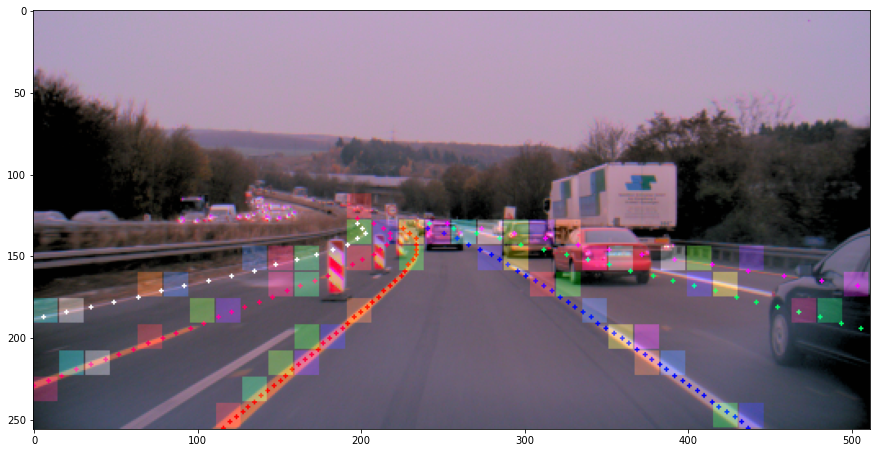

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


grid_y = int(img_orig.shape[1] / 16) #h
grid_x = int(img_orig.shape[2] / 16) #w

img = img_orig.permute(1, 2, 0).contiguous()
img = img.numpy()
# img = np.transpose(img_orig, (1, 2, 0)).astype('float32')
img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
img = (img * 255).astype(np.uint8)
blk = np.zeros(img.shape, np.uint8)


for i in range(len(lane_set)):
    
    cx = lane_set[i].ax
    cy = lane_set[i].ay
    g_ind_x = int(cx / 16)
    g_ind_y = int(cy / 16)
    grid_pt1 = (g_ind_x * 16, g_ind_y * 16)
    grid_pt2 = (g_ind_x * 16 + 14, g_ind_y * 16 + 14)
    cv2.rectangle(blk, grid_pt1, grid_pt2, get_color(i), cv2.FILLED)
    
    for pt in lane_set[i].lane:
        if pt.x > 0:
            x = int(pt.x)
            y = int(pt.y)
            ###
            '''
            g_ind_x = int(x / 16)
            g_ind_y = int(y / 16)
            grid_pt1 = (g_ind_x * 16, g_ind_y * 16)
            grid_pt2 = (g_ind_x * 16 + 16, g_ind_y * 16 + 16)
            cv2.rectangle(blk, grid_pt1, grid_pt2, get_color(lane_idx), cv2.FILLED)
            '''
            ###
            cv2.circle(img, (x,y), 1, get_color(i), -1)


# print(lane_idx)
out = cv2.addWeighted(img, 1.0, blk, 0.25, 1)

plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.imshow(blk)
plt.imshow(out)
plt.show() 

In [3]:
model = build_lane_detection_model(cfg)

In [4]:
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer

In [5]:
save_dir = os.path.join(cfg.OUTPUT_DIR, 'test')
checkpointer = DetectronCheckpointer(cfg, model, save_dir=save_dir)
ckpt = 'exp/test/model_0090000.pth'
_ = checkpointer.load(ckpt, use_latest=False)

In [6]:
import os, glob
path = 'datasets/lane_detection/test/images/'
pattern = os.path.join(path, '*.bmp')
img_paths = glob.glob(pattern)

In [7]:
from maskrcnn_benchmark.data.utils.auto_lane_pointlane_codec  import PointLaneCodec
from maskrcnn_benchmark.data.utils.auto_lane_codec_utils import nms_with_pos
from maskrcnn_benchmark.data.utils.auto_lane_utils import get_img_whc, imread, load_module
from maskrcnn_benchmark.data.utils.auto_lane_utils import load_lines, resize_by_wh, bgr2rgb, imagenet_normalize, load_json

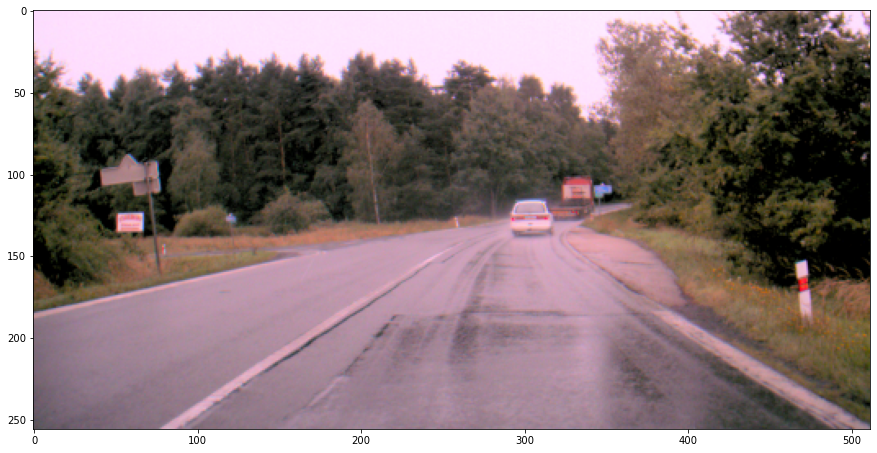

In [93]:
idx = 1913 # 31643 1908 1909 1913

image_arr = imread(img_paths[idx])
network_input_image = bgr2rgb(resize_by_wh(img=image_arr, 
                width=512, height=256))
img = imagenet_normalize(img=network_input_image)
img = np.transpose(img, (2, 0, 1)).astype('float32')
img = torch.from_numpy(img).float() 

import matplotlib.pyplot as plt
import numpy as np
import cv2
plt.figure(figsize=(15, 15))
plt.imshow(network_input_image)
plt.show() 

In [94]:
model.eval()
predicts, instances = model(img.view(1,img.size(0),img.size(1),img.size(2)))

pointlane_codec = PointLaneCodec(
    input_width=512,
    input_height=256,
    anchor_stride=16,
    points_per_line=80,
    class_num=2)

predict_loc = predicts['predict_loc'].detach().numpy()
predict_conf = F.softmax(predicts['predict_cls'], -1).detach().numpy()

lane_set, grid_set = pointlane_codec.decode_lane(
    predict_type=predict_conf[0],
    predict_loc=predict_loc[0], 
    cls_thresh=0.6)
lane_nms_set = nms_with_pos(lane_set, thresh=60)

In [95]:
ins = instances[-1]
bs = ins.size(0)
fs = 4


ins = ins.permute((0, 2, 3, 1)).contiguous() # =>[N, grid_h, grid_w, 4]
ins = ins.view(bs, -1, fs) # =>[N, grid_h*grid_w, 4]
predict_ins = ins.detach().cpu().numpy()[0]
print(predict_ins.shape)


feature = predict_ins[grid_set]
lane_feature = []
lane_grid = []
    
for i in range(feature.shape[0]):
    if (np.sum(feature[i]**2))>=0:

        if len(lane_feature) == 0:
            # create new lane
            lane_feature.append(feature[i])
            lane_grid.append([ i ])
            
        else:
            flag = 0
            index = 0
            min_feature_index = -1
            min_feature_dis = 10000

            for feature_idx, j in enumerate(lane_feature):
                dis = np.linalg.norm((feature[i] - j)**2)
                if min_feature_dis > dis:
                    min_feature_dis = dis # dist to this lane feat
                    min_feature_index = feature_idx # lane id

            if min_feature_dis <= 0.08:
                temp_feat = lane_feature[min_feature_index]
                n_grid = len(lane_grid[min_feature_index]) 
                # lane feat + cur grid feat
                lane_feature[min_feature_index] = (temp_feat * n_grid + feature[i]) / (n_grid + 1)
                lane_grid[min_feature_index].append( i )

            elif len(lane_feature) < 12:
                # create new lane
                lane_feature.append(feature[i])
                lane_grid.append([ i ])

(512, 4)


In [96]:
lines = list()
for it in lane_grid:
    line = list()
    for i in it:
        line.append(lane_set[i])
    lines.append(line)
    
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i//m]


In [139]:
len(lines[2])

13

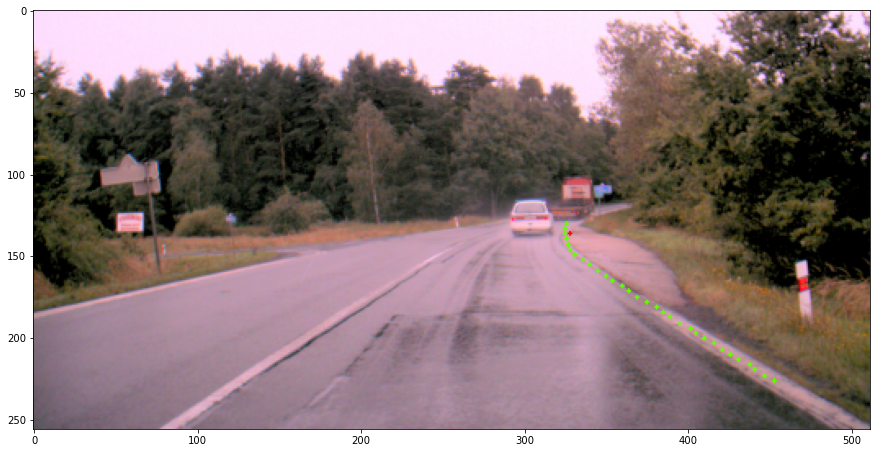

In [151]:
#blk = np.zeros(network_input_image.shape, np.uint8)
import copy
im = copy.deepcopy(network_input_image)
stride = 128.
'''
for lid, line_set in enumerate(lines):
    for i, l in enumerate(line_set):
        line = l.lane
        ax,ay = l.ax,l.ay
        bound_x = [(ax-stride), (ax+stride)]
        bound_y = [(ay-stride), (ay+stride)]
        for pt in line:
            x = int(pt.x)
            y = int(pt.y)

            if x > bound_x[0]  and x < bound_x[1] and y > bound_y[0] and y < bound_y[1]:
                cv2.circle(im, (x, y), 1, get_color(lid), -1)
'''


idx = 0
l = lines[2][idx]
line = l.lane
ax,ay = l.ax,l.ay
bound_x = [(ax-stride), (ax+stride)]
bound_y = [(ay-stride), (ay+stride)]
for pt in line:
    x = int(pt.x)
    y = int(pt.y)

    if x > bound_x[0]  and x < bound_x[1] and y > bound_y[0] and y < bound_y[1]:
        cv2.circle(im, (x, y), 1, (100,255,0), -1)
cv2.circle(im, (int(ax), int(ay)), 1, (255,0,0), -1)

#out = cv2.addWeighted(network_input_image, 1.0, blk, 0.25, 1)        
plt.figure(figsize=(15, 15))
plt.imshow(im)
#plt.imshow(blk)
#plt.imshow(out)
plt.show() 

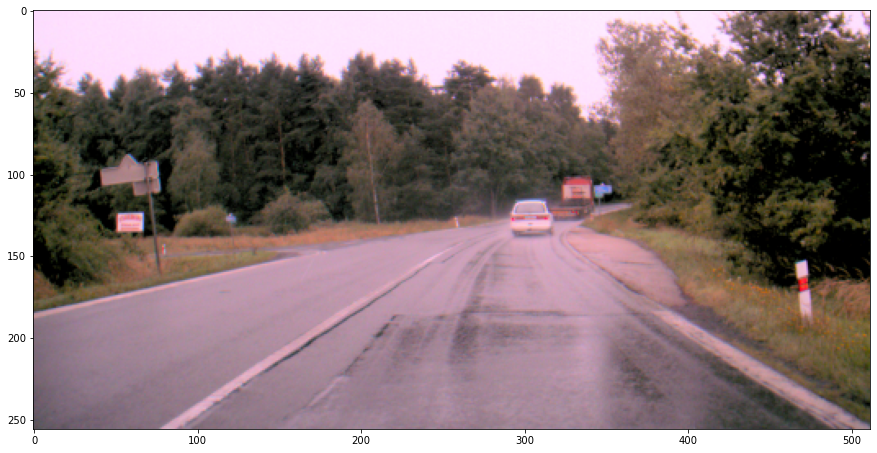

In [132]:
plt.figure(figsize=(15, 15))
plt.imshow(network_input_image)

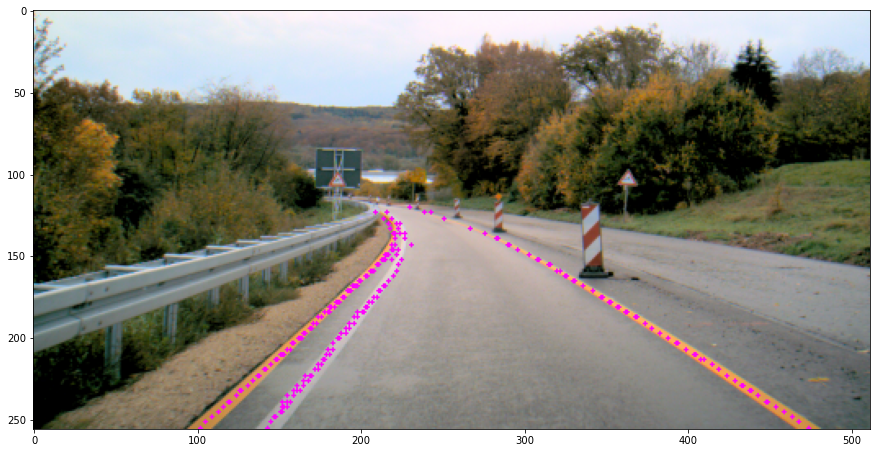

In [55]:
#blk = np.zeros(network_input_image.shape, np.uint8)
import copy
im = copy.deepcopy(network_input_image)
stride = 17.

for i, l in enumerate(lane_set):
    line = l.lane
    ax,ay = l.ax,l.ay
    bound_x = [(ax-stride), (ax+stride)]
    bound_y = [(ay-stride), (ay+stride)]
    for pt in line:
        x = int(pt.x)
        y = int(pt.y)
        
        if x > bound_x[0]  and x < bound_x[1] and y > bound_y[0] and y < bound_y[1]:
            cv2.circle(im, (x, y), 1, (255,0,255), -1)

#out = cv2.addWeighted(network_input_image, 1.0, blk, 0.25, 1)        
plt.figure(figsize=(15, 15))
plt.imshow(im)
#plt.imshow(blk)
#plt.imshow(out)
plt.show() 

In [37]:
lane_nms_set

In [38]:
lines = [ [ [pt.x, pt.y] for pt in l.lane if pt.x >= .0] for l in lane_nms_set]

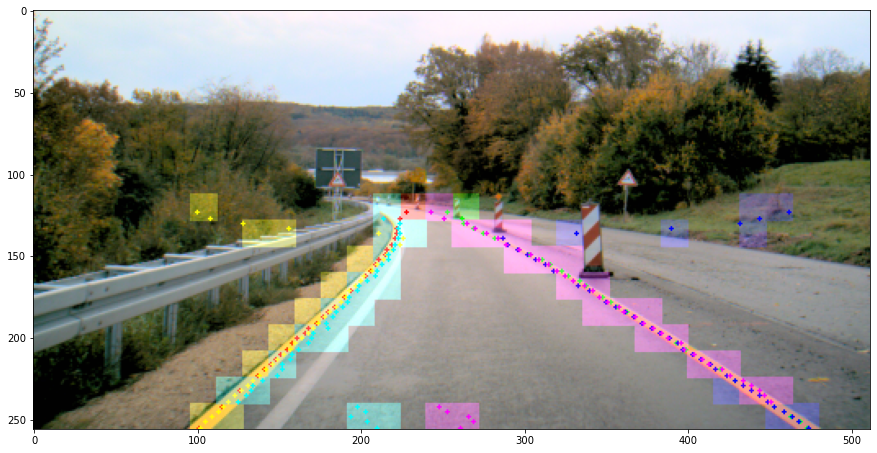

In [43]:
# red, green, blue, yellow, pink, sea, wite, green
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i//m]

blk = np.zeros(network_input_image.shape, np.uint8)
for i, line in enumerate(lines):
    for pt in line:
        x = int(pt[0])
        y = int(pt[1])
            
        g_ind_x = int(x / 16)
        g_ind_y = int(y / 16)
        grid_pt1 = (g_ind_x * 16, g_ind_y * 16)
        grid_pt2 = (g_ind_x * 16 + 16, g_ind_y * 16 + 16)
        cv2.rectangle(blk, grid_pt1, grid_pt2, get_color(i), cv2.FILLED)
        
        
        cv2.circle(network_input_image, (x, y), 1, get_color(i), -1)

out = cv2.addWeighted(network_input_image, 1.0, blk, 0.25, 1)        
plt.figure(figsize=(15, 15))
plt.imshow(network_input_image)
plt.imshow(blk)
plt.imshow(out)
plt.show() 

In [3]:
################## Inference

pred = torch.load("exp/aicom/inference/aicom_lane_test/predictions.pth", 
                  map_location=torch.device("cpu")) # oct20 aicom

from maskrcnn_benchmark.data.utils.auto_lane_codec_utils import nms_with_pos
import matplotlib.pyplot as plt
import numpy as np
import cv2, os, glob
paths = os.path.join('datasets/lane_detection/test/images','*.bmp')
paths = glob.glob(paths)
def get_imgs(idx):
    return cv2.imread(paths[idx])

 lines num: 6 


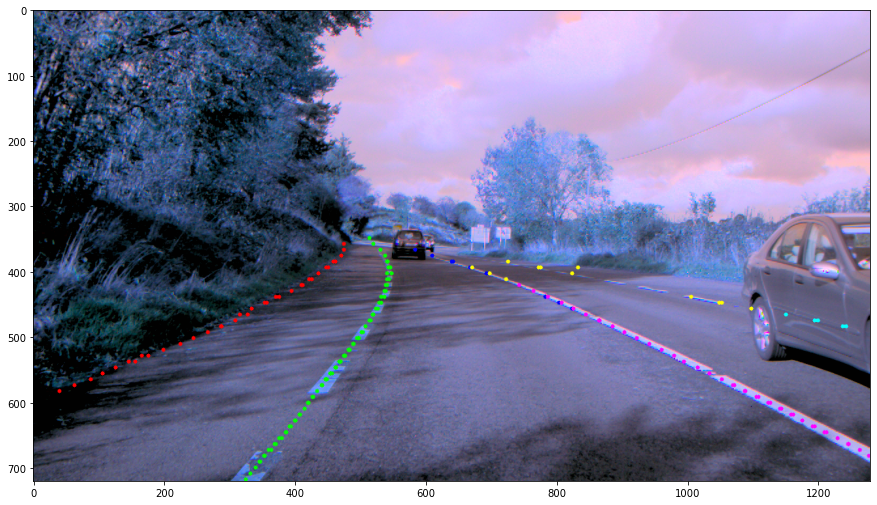

In [4]:
idx = 7 # 2 7 8 9
stride = 16.
im = get_imgs(idx)
rx, ry = 1280/512., 720/256.

blk = np.zeros(im.shape, np.uint8)
for i, it in enumerate(pred[idx]):
    # it = nms_with_pos(it, thresh=60)
    for l in it:
        line = l.lane
        ax,ay = l.ax,l.ay
        bound_x = [(ax-stride)*rx, (ax+stride)*rx]
        bound_y = [(ay-stride)*ry, (ay+stride)*ry]
        for pt in line:
            x = int(pt.x*rx)
            y = int(pt.y*ry)

            if x > bound_x[0]  and x < bound_x[1] and y > bound_y[0] and y < bound_y[1]:
                cv2.circle(im, (x, y), 3, get_color(i), -1)
        #cv2.circle(im, (int(ax*rx), int(ay*ry)), 4, (255,0,0), -1)
        #cv2.rectangle(blk, (int((ax-16)*rx), int((ay-8)*ry)), (int((ax+16)*rx), int((ay+8)*ry)), 
        #              (255,0,0), cv2.FILLED)

out = cv2.addWeighted(im, 1.0, blk, 0.25, 1)    
print(" lines num: {} ".format( len(pred[idx]) ))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.imshow(blk)
plt.imshow(out)
plt.show() 
# red, green, blue, yellow, pink, sea, wite, green

 lines num: 7 


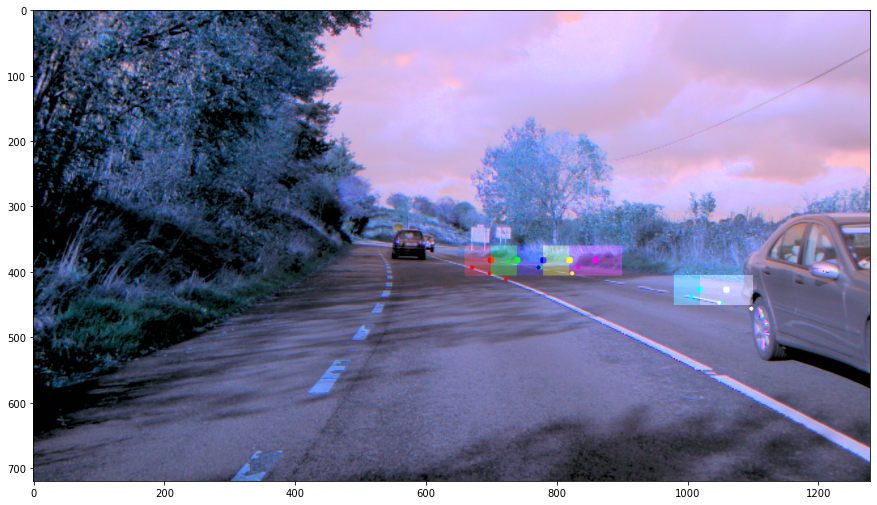

In [5]:
idx = 7 # 2 7 8 9
stride = 16.
im = get_imgs(idx)

blk = np.zeros(im.shape, np.uint8)

outline = list()
it = pred[idx][3]
for i, l in enumerate(it):
    line = l.lane
    ax,ay = l.ax,l.ay
    bound_x = [(ax-stride)*rx, (ax+stride)*rx]
    bound_y = [(ay-stride)*ry, (ay+stride)*ry]
    for pt in line:
        x = int(pt.x*rx)
        y = int(pt.y*ry)
        
        if x > bound_x[0]  and x < bound_x[1] and y > bound_y[0] and y < bound_y[1]:
            cv2.circle(im, (x, y), 3, get_color(i), -1)
            outline.append([x,y])
    cv2.circle(im, (int(ax*rx), int(ay*ry)), 5, get_color(i), -1)
    cv2.rectangle(blk, (int((ax-16)*rx), int((ay-8)*ry)), (int((ax+16)*rx), int((ay+8)*ry)), 
                  get_color(i), cv2.FILLED)

out = cv2.addWeighted(im, 1.0, blk, 0.25, 1)    
print(" lines num: {} ".format( len(it) ))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.imshow(blk)
plt.imshow(out)
plt.show() 

In [6]:
oline = sorted(outline, key=lambda pt: pt[1], reverse=True)
xs = [pt[0] for pt in oline]
ys = [pt[1] for pt in oline]
xs,ys

([1098, 1053, 1049, 1006, 723, 698, 824, 671, 776, 773, 833, 726],
 [456, 447, 447, 438, 411, 402, 402, 393, 393, 393, 393, 384])

In [7]:
import maskrcnn_benchmark.engine.post_process as util
from copy import deepcopy

In [10]:
in_x = [xs]
in_y = [ys]
in_x, in_y = util.sort_along_y(in_x, in_y)  
in_x, in_y = eliminate_out(in_x, in_y)
#in_x, in_y = eliminate_out(xs, ys)

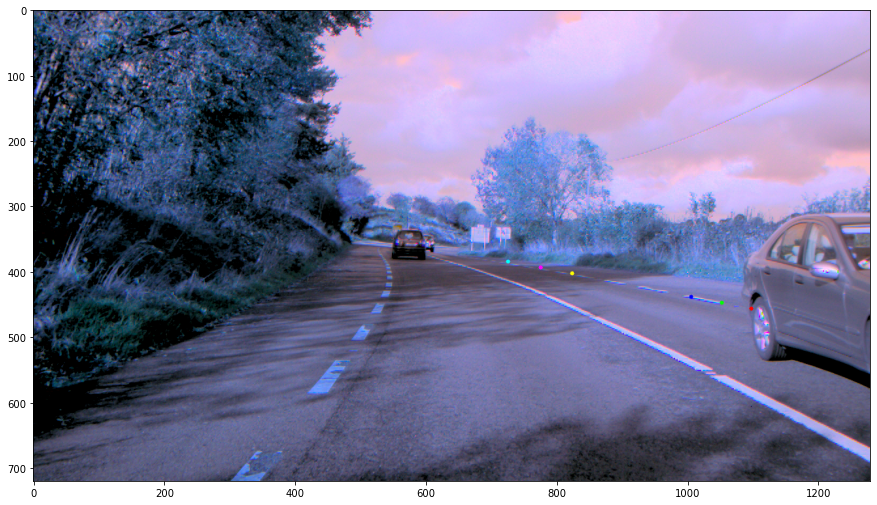

In [11]:
im = get_imgs(idx)
for i,(x,y) in enumerate(zip(in_x[0], in_y[0])):
    x = int(x)
    y = int(y)
    cv2.circle(im, (x, y), 3, get_color(i), -1)

plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [12]:
lane_x_along_y = np.array(deepcopy(xs))
lane_y_along_y = np.array(deepcopy(ys))

ind = np.argsort(lane_x_along_y, axis=0)
lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)

In [13]:
lane_x_along_x, lane_y_along_x

(array([ 671,  698,  723,  726,  773,  776,  824,  833, 1006, 1049, 1053,
        1098]),
 array([393, 402, 411, 384, 393, 393, 402, 393, 438, 447, 447, 456]))

In [14]:
lane_y_along_x[0], lane_y_along_x[-1]

(393, 456)

In [15]:
if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
    starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                       (lane_x_along_y[1], lane_y_along_y[1]), 
                       (lane_x_along_y[2], lane_y_along_y[2]),
                       (lane_x_along_x[0], lane_y_along_x[0]), 
                       (lane_x_along_x[1], lane_y_along_x[1]), 
                       (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
else:
    starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                       (lane_x_along_y[1], lane_y_along_y[1]), 
                       (lane_x_along_y[2], lane_y_along_y[2]),
                       (lane_x_along_x[-1], lane_y_along_x[-1]), 
                       (lane_x_along_x[-2], lane_y_along_x[-2]), 
                       (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x 

In [17]:
start_point = starting_points[0]
lane_x, lane_y = start_point[0], start_point[1]
points = util.get_closest_upper_point(xs, ys, start_point, 3)

In [19]:
points, start_point

([(1053, 447), (1049, 447), (1006, 438)], (1098, 456))

In [9]:
def eliminate_out(sorted_x, sorted_y, confidence = None, image = None):
    out_x = []
    out_y = []

    for lane_x, lane_y in zip(sorted_x, sorted_y):

        lane_x_along_y = np.array(deepcopy(lane_x))
        lane_y_along_y = np.array(deepcopy(lane_y))

        ind = np.argsort(lane_x_along_y, axis=0)
        lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
        lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)
        
        if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[0], lane_y_along_x[0]), 
                               (lane_x_along_x[1], lane_y_along_x[1]), 
                               (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
        else:
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[-1], lane_y_along_x[-1]), 
                               (lane_x_along_x[-2], lane_y_along_x[-2]), 
                               (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x            
    
        temp_x = []
        temp_y = []
        for start_point in starting_points:
            temp_lane_x, temp_lane_y = generate_cluster(start_point, lane_x, lane_y, image)
            temp_x.append(temp_lane_x)
            temp_y.append(temp_lane_y)
        
        max_lenght_x = None
        max_lenght_y = None
        max_lenght = 0
        for i, j in zip(temp_x, temp_y):
            if len(i) > max_lenght:
                max_lenght = len(i)
                max_lenght_x = i
                max_lenght_y = j
        out_x.append(max_lenght_x)
        out_y.append(max_lenght_y)

    return out_x, out_y


# image is useless
def generate_cluster(start_point, lane_x, lane_y, image = None):
    cluster_x = [start_point[0]]
    cluster_y = [start_point[1]]

    point = start_point
    while True:
        points = util.get_closest_upper_point(lane_x, lane_y, point, 3)
         
        max_num = -1
        max_point = None

        if len(points) == 0:
            break
        if len(points) < 3:
            for i in points: 
                cluster_x.append(i[0])
                cluster_y.append(i[1])                
            break
        for i in points: 
            # choose i that line(point->i) is closest to remaining points
            num, shortest = util.get_num_along_point(lane_x, lane_y, point, i, image)
            if max_num < num:
                max_num = num
                max_point = i

        total_remain = len(np.array(lane_y)[np.array(lane_y) < point[1]])
        cluster_x.append(max_point[0])
        cluster_y.append(max_point[1])
        point = max_point
        
        if len(points) == 1 or max_num < total_remain/5:
            break

    return cluster_x, cluster_y

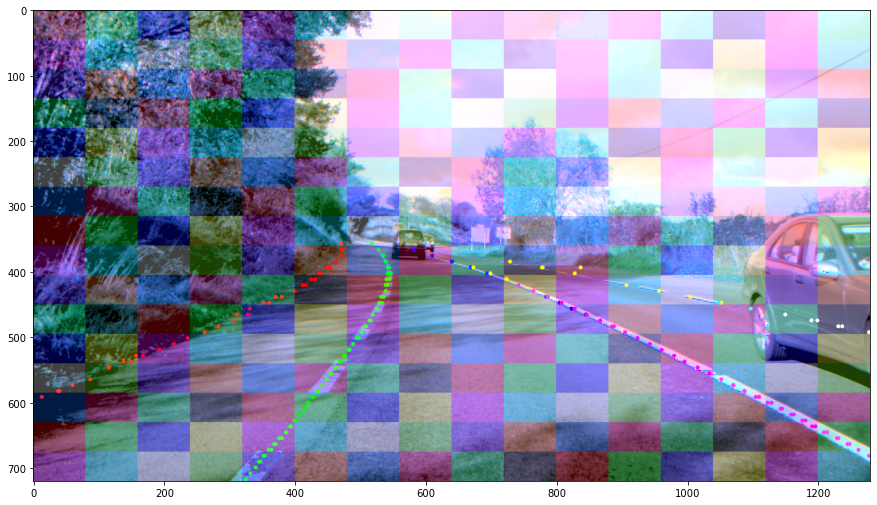

In [19]:
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    if i < m:
        return color[i]  
    else:
        return color[i%m]

blk = np.zeros(im.shape, np.uint8)
i = 0
for h in range(16):
    for w in range(32):
        p1 = ( int(w*32*rx), int(h*16*ry) )
        p2 = ( int((w+1)*32*rx), int((h+1)*16*ry) )
        cv2.rectangle(blk, p1, p2, get_color(i), cv2.FILLED)
        i += 1

out = cv2.addWeighted(im, 1.0, blk, 0.25, 1)        
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.imshow(blk)
plt.imshow(out)
plt.show() 

In [1]:
import random

In [5]:
n = 0
for i in range(800):
    if random.random()<0.15:
        n += 1
print(n, n*48/(800.0*48) )

118 0.1475


In [6]:
0.15**48

2.8338733342846597e-40

In [4]:
import logging
print("lr:{:e}".format(0.00000001))

lr:1.000000e-08


In [6]:
import torch
corner_case = torch.load("corner_case/torner_case_0084500.pth", map_location=torch.device("cpu"))
corner_ids = corner_case.get_ids()

In [24]:
def get_img(img_id):
    path = os.path.join("datasets/lane_detection/images/", 
                        training_dataset[img_id]["img_path"] + ".bmp")
    return cv2.imread(path)
def get_lines(img_id):
    return training_dataset[img_id]['lanes']

import json
with open("datasets/lane_detection/trainset.json", "r") as ann_file:
    training_dataset = json.load(ann_file)

color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]


img_id = corner_ids[954]
im = get_img(img_id)
for lid, l in enumerate( get_lines(img_id) ):
    for x,y in l:
        x,y = int(x),int(y)
        cv2.circle(im, (x,y), 3, color[lid], -1)
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [90]:
import torch
inputs = []
for i in range(4):
    cp = torch.load("ooooooooooooooooooo_{}.pth".format(i), map_location=torch.device("cpu"))
    inputs.append(cp)
    

In [98]:
out = {}
for i in range(4):
    for k, v in inputs[i].items():
        out[k.item()] = v

In [102]:
import copy
out2 = copy.deepcopy(out)
out2 = sorted(out2.items(), key=lambda x:x[0])

In [241]:
torch.save(out2, "img_loss_oct29.pth")

In [104]:
import copy
out3 = copy.deepcopy(out)
out3 = sorted(out3.items(), key=lambda x:x[1])

In [235]:
weights = [0.2, 0.8, 0.02, 0.]
weights = torch.tensor(weights, dtype=torch.float)
classes_for_imgs = []
for idx, loss in out2:
    if loss <= 3.:
        classes_for_imgs.append(0)
    elif loss > 3. and loss <= 7.:
        classes_for_imgs.append(1)
    elif loss > 7. and loss <= 10.:
        classes_for_imgs.append(2)
    else:
        classes_for_imgs.append(3)
samples_weights = weights[classes_for_imgs]

In [239]:
# torch.utils.data.sampler.WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=samples_weights, 
                                       num_samples=len(samples_weights), 
                                       replacement=True)
inds = list(sampler)

In [242]:
rand_tensor = torch.multinomial(torch.as_tensor(samples_weights, dtype=torch.double), 
                                len(samples_weights), 
                                True)
inds = rand_tensor.tolist()

In [240]:
print(len(inds))
acc = 0
for i in inds:
    if i in xs:
        acc += 1
print(acc)

79992
60


In [118]:
ws = [0.01, 0.05, 0.9]
ws = torch.tensor(ws, dtype=torch.float)
test = [0,1,2,2,1,0,0]
sw = ws[test]
sw

tensor([0.0100, 0.0500, 0.9000, 0.9000, 0.0500, 0.0100, 0.0100])

In [119]:
import matplotlib.pyplot as plt

2150 0.026877687768776876


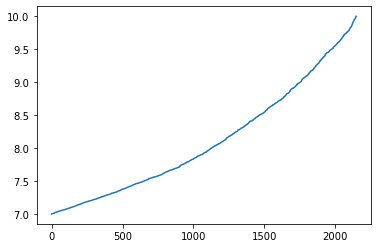

In [230]:
xs = [k for k,v in out3 if v < 10. and v > 7.]
ys = [v for k,v in out3 if v < 10. and v > 7.]
#plt.plot(xs,ys)
print(len(ys), len(ys)*1.0/len(out3))
plt.plot(ys)

In [122]:
max(ys), min(ys)

(inf, 0.16210340784164146)

170


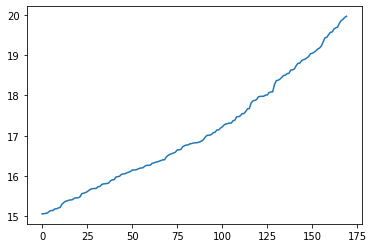

In [189]:
import math
tmploss = [v for k,v in out3]
tmpid   = [k for k,v in out3]
#tmp = [i for i in tmploss if i!=math.inf and i < 50. and i > 20.]
tmp =  [i for k,i in zip(tmpid,tmploss) if i!=math.inf and i < 20. and i > 15.]
tmpk = [k for k,i in zip(tmpid,tmploss) if i!=math.inf and i < 20. and i > 15.]
print(len(tmp))
plt.plot(tmp)

In [151]:
json_path = os.path.join('datasets/lane_detection', 'trainset_v04.json')
with open(json_path, 'r') as f:
    json_data_for_train2 = json.load(f)
len(json_data_for_train2)

79992

In [152]:
def get_img(img_id):
    path = os.path.join("datasets/lane_detection/images/", 
                        json_data_for_train2[img_id]["img_path"] + ".bmp")
    return cv2.imread(path)
def get_lines(img_id):
    return json_data_for_train2[img_id]['lanes']

In [166]:
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

from maskrcnn_benchmark.utils.miscellaneous import mkdir
folder_path = './out_img/gt_02'
mkdir(folder_path)
#img_id = 45332
for img_id in tmpk:
    im = get_img(img_id)
    for lid, l in enumerate( get_lines(img_id) ):
        for x,y in l:
            x,y = int(x),int(y)
            cv2.circle(im, (x,y), 3, color[lid], -1)
    #plt.figure(figsize=(15, 15))
    #plt.imshow(im)
    #plt.show() 
    path = os.path.join(folder_path, 'pred_{}.png'.format(img_id))
    cv2.imwrite(path, im)

In [174]:
inp=[0.1, 0.9, 0.1, 0.9, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1]
inps=torch.tensor(inp)
# torch.multinomial(inps, len(inp), replacement=True)
samp = torch.utils.data.sampler.WeightedRandomSampler(inps, len(inp))
list(samp)

[0, 1, 3, 3, 3, 1, 1, 1, 1, 1]